In [ ]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dk(self, X):
    x1, y1, z1, x2, y2, z2 = X
    return [y1 + b*x1**2 - a*x1**3 -z1 + I - k1*(x1-vs)*G(x2),
            c - d*x1**2 - y1,
            r*(s*(x1 - xr) - z1),
            y2 + b*x2**2 - a*x2**3 -z2 + I - k2*(x2-vs)*G(x1),
            c - d*x2**2 - y2,
            r*(s*(x2 - xr) - z2)        
    ]
 
def G(x):
    return 1/(1+np.exp(-lam*(x-teta)))

In [3]:
a = 1
b = 3
c = 1
d = 5
xr = -1.6
r = 0.01
s = 5
I = 4
vs = 2
lam = 10
teta = -0.25
k1 = -0.17
k2 = -0.17

In [4]:
#sol = solve_ivp(dk, [0, 25200], [-0.1, 0.1, -0.1, -0.1, -0.1, -0.1], 
                #t_eval=np.array(range(200, 25200, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to('cuda'),
                            torch.zeros(1,1,self.hidden_layer_size).to('cuda'))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [7]:
#np.save('DK_time_series_for_new_loss', sol.y)

In [15]:
data = np.load("DK_time_series_for_new_loss.npy")
data = data[0] + data[3]

train = data[:10000]
test =  data[10000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

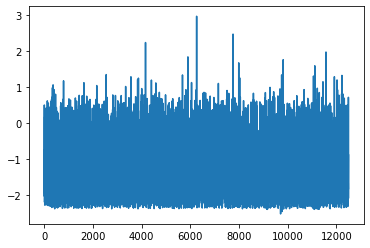

In [18]:
plt.plot(data)

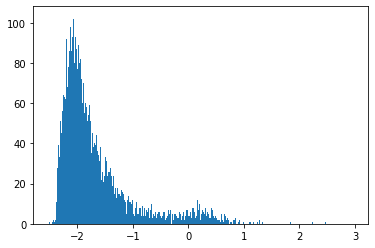

In [17]:
plt.hist(data, 1000)
plt.show()

In [7]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [8]:
from IPython.display import clear_output

In [26]:
def gevl_loss(y_pred, y_true, gamma=1):
    u = y_pred - y_true  
    return (1-torch.exp(-u**2))*gamma*u**2

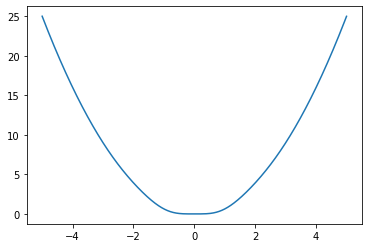

In [25]:
x = list(np.arange(-5, 5, 0.001))
plt.plot(x, (1-torch.exp(-torch.FloatTensor(x).view(-1)**2))*1*torch.FloatTensor(x).view(-1)**2)

In [36]:
def Frechet_loss(y_pred, y_true, alpha=10, s=1.7):
    u = torch.abs(y_pred - y_true)
    #u[0] = max(u[0], -1)
    #print(u)
    K = alpha/s*((u+s*(alpha/(1+alpha))**(1/alpha))/s)**(-1-alpha)
    return -torch.log(K) + ((u+s*(alpha/(1+alpha))**(1/alpha))/s)**-alpha

In [35]:
u = torch.FloatTensor([-2]).view(-1)
Frechet_loss(u, 0)

tensor([nan])

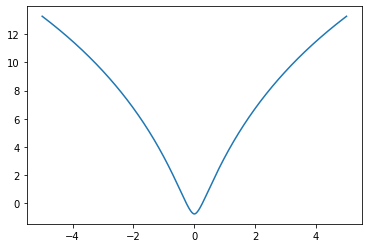

In [39]:
x = torch.FloatTensor(list(np.arange(-5, 5, 0.001))).view(-1)
plt.plot(x, Frechet_loss(x, 0))

In [83]:
u = torch.tensor([-2.2])
#u[0] = max(u[0], -1)
alpha=13
s=1.7
K = alpha/s*((u+s*(alpha/(1+alpha))**(1/alpha))/s)**(-1-alpha)
-torch.log(K) + ((u+s*(alpha/(1+alpha))**(1/alpha))/s)**-alpha

tensor([-6326329.5000])

In [ ]:
((u+s*(alpha/(1+alpha))**(1/alpha))/s)**-alpha

In [76]:
K

tensor([2.6891e+38])

In [92]:
model = LSTM().to('cuda')

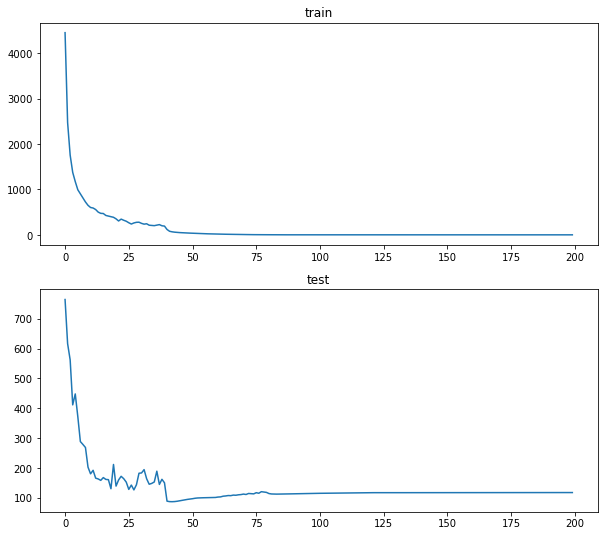

Epoch[200/200] | loss train:1.657696, test:117.710708 | lr:0.000000


In [28]:
def run_epoch(train_inout_seq, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for seq, label in train_inout_seq:
        if is_training:
            optimizer.zero_grad()
            
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        y_pred = model(seq.to('cuda'))

        
        loss = criterion(y_pred, label.to('cuda'))

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.detach().item() 

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# define optimizer, scheduler and loss function
criterion = gevl_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train, lr_train = run_epoch(train_inout_seq, is_training=True)
    loss_val, lr_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val, lr_train))

In [29]:
torch.save(model.state_dict(), "./New_loss_dk")

In [93]:
model.load_state_dict(torch.load("./New_loss_dk"))

<All keys matched successfully>

In [94]:
model.eval()
model.to('cpu')
rmse = []
for k in range(1, 21):
    #k = 3
    last_k_step = test_norm[:k].tolist()
    prediction = []
    for seq, label in test_inout_seq:
        loop_steps = seq.tolist()
        #print(len(last_k_step))
        for j in range(k):
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(torch.FloatTensor(loop_steps).view(-1))
            loop_steps.append(y_pred.detach()[0].item())
            loop_steps = loop_steps[1:]
            #print(len(loop_steps))
        clear_output(True)
        prediction.append(loop_steps[-1])
        #last_k_step.append(test_norm[i])
        #last_k_step = last_k_step[1:]
    if k == 1:
        r = (((np.array(prediction)*std+mean - np.array(test[20:]))**2).mean())**0.5
    else:
        r = (((np.array(prediction[:-k+1])*std+mean - np.array(test[20+k-1:]))**2).mean())**0.5
    rmse.append(r)

Text(0.5, 0, 'prediction step')

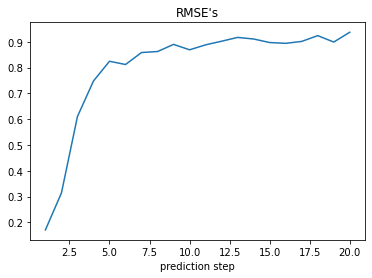

In [96]:
plt.plot(list(range(1, 21)), rmse)
plt.title("RMSE's")
plt.xlabel("prediction step")

In [30]:
model.eval()
model.to('cpu')
k = 1
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(torch.FloatTensor(loop_steps).view(-1))
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

In [31]:
(((np.array(prediction)*std+mean - np.array(test[20:]))**2).mean())**0.5

0.17109309345871304

# Some gamma experements

In [22]:
def run_epoch(train_inout_seq, is_training=False, gamma=1):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for seq, label in train_inout_seq:
        if is_training:
            optimizer.zero_grad()
            
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        y_pred = model(seq.to('cuda'))

        
        loss = criterion(y_pred, label.to('cuda'), gamma)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.detach().item() 

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# gamma = 2

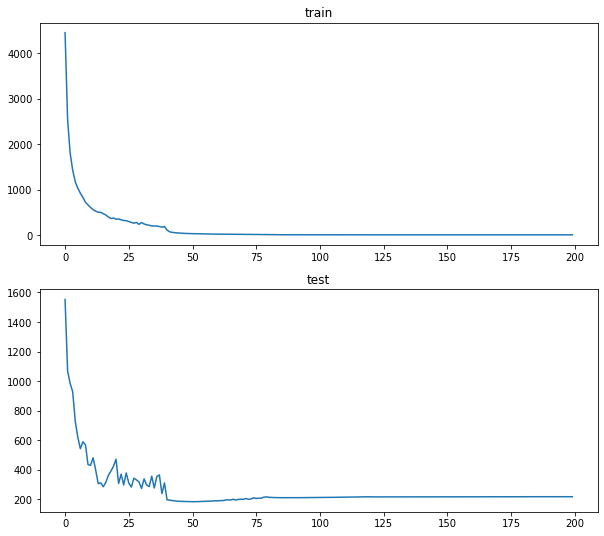

Epoch[200/200] | loss train:3.456254, test:217.319137 | lr:0.000000


In [14]:
# define optimizer, scheduler and loss function
criterion = gevl_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train, lr_train = run_epoch(train_inout_seq, is_training=True)
    loss_val, lr_val = run_epoch(test_inout_seq, gamma=2)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val, lr_train))

In [15]:
model.eval()
model.to('cpu')
k = 1
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(torch.FloatTensor(loop_steps).view(-1))
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

In [16]:
(((np.array(prediction)*std+mean - np.array(test[20:]))**2).mean())**0.5

0.1674494645719259

# Frechet loss

In [28]:
def run_epoch(train_inout_seq, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for seq, label in train_inout_seq:
        if is_training:
            optimizer.zero_grad()
            
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        y_pred = model(seq.to('cuda'))

        
        loss = criterion(y_pred, label.to('cuda'))

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.detach().item() 

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [18]:

# define optimizer, scheduler and loss function
criterion = gevl_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train, lr_train = run_epoch(train_inout_seq, is_training=True)
    loss_val, lr_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
#     clear_output(True)
#     fig = plt.figure(figsize=(10, 9))
    
#     ax_1 = fig.add_subplot(2, 1, 1)
#     ax_2 = fig.add_subplot(2, 1, 2)
#     ax_1.set_title('train')
#     ax_1.plot(losses_train)
#     ax_2.set_title('test')
#     ax_2.plot(losses_test)
#     plt.show()
    
#     print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
#               .format(epoch+1, 200, loss_train, loss_val, lr_train))

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([nan], device='cuda:0', grad_fn=<SubBackward0>)
tensor([na

KeyboardInterrupt: 

In [90]:
model = LSTM().to('cuda')

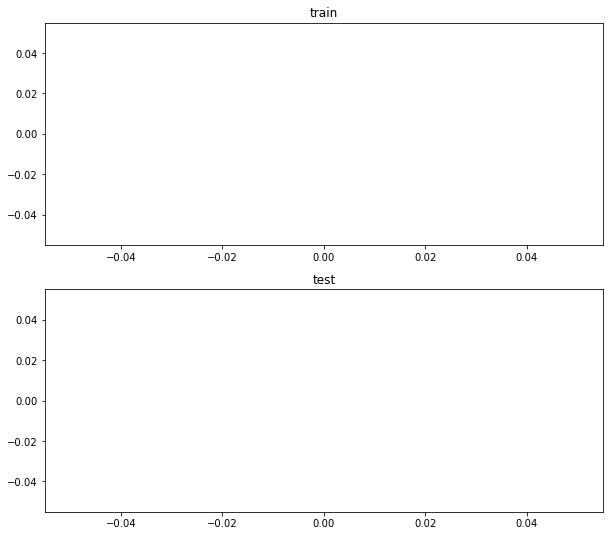

Epoch[1/200] | loss train:nan, test:nan | lr:0.001000


KeyboardInterrupt: 

In [91]:
# define optimizer, scheduler and loss function
criterion = Frechet_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train, lr_train = run_epoch(train_inout_seq, is_training=True)
    loss_val, lr_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val, lr_train))

# Старый лосс

In [63]:
model = LSTM().to('cuda')

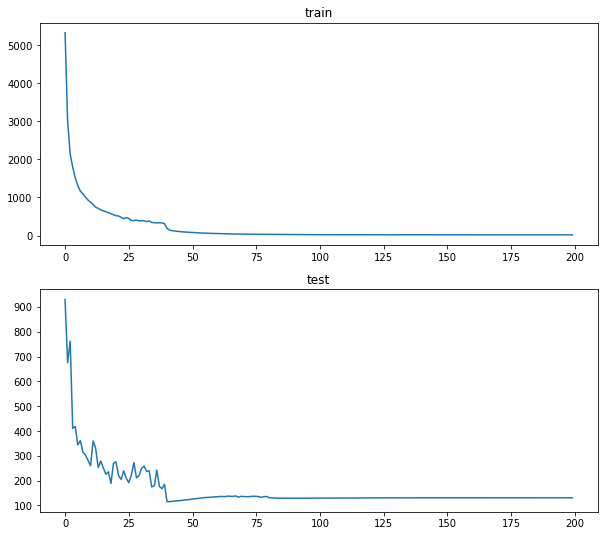

Epoch[200/200] | loss train:20.147353, test:131.007818 | lr:0.000000


In [35]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train, lr_train = run_epoch(train_inout_seq, is_training=True)
    loss_val, lr_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val, lr_train))

In [36]:
model.eval()
model.to('cpu')
k = 1
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(torch.FloatTensor(loop_steps).view(-1))
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

In [37]:
(((np.array(prediction)*std+mean - np.array(test[20:]))**2).mean())**0.5

0.1547160136340754

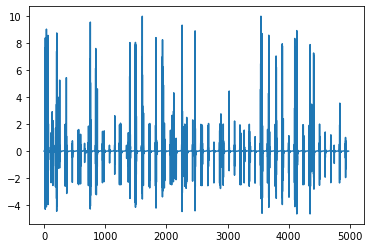

In [14]:
plt.plot(prediction)

In [32]:
model.eval()
model.to('cpu')
k = 1
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(torch.FloatTensor(loop_steps).view(-1))
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

In [33]:
(((np.array(prediction)*std+mean - np.array(test[20:]))**2).mean())**0.5

0.17109309345871304

# FFNN

In [38]:
model = nn.Sequential(
          nn.Linear(1, 100),
          nn.Sigmoid(),
          nn.Linear(100, 1)
        )
model.to('cuda')

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [43]:
X = torch.FloatTensor(train[:-1]).view(-1 ,1)
Y = torch.FloatTensor(train[1:]).view(-1 ,1)
X.size() == Y.size()

True

In [44]:
X_t = torch.FloatTensor(test[:-1]).view(-1 ,1)
Y_t = torch.FloatTensor(test[1:]).view(-1 ,1)
X_t.size() == Y_t.size()

True

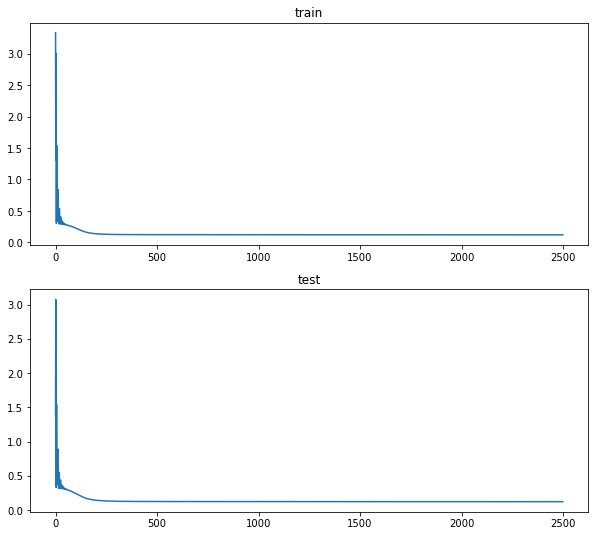

0.12048739194869995


In [45]:
epochs = 2500
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
losses = []
val_losses = []
model.train()
for i in range(epochs):
    #train
    epoch_loss = []
    val_epoch_loss = []
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(X.to('cuda'))

    single_loss = gevl_loss(y_pred, Y.to('cuda')).mean()
    single_loss.backward()
    optimizer.step()
    epoch_loss.append(single_loss.item())
    
    #valid
    model.eval()
    y_pred = model(X_t.to('cuda'))

    single_loss = nn.MSELoss()(y_pred, Y_t.to('cuda')).mean()
    val_epoch_loss.append(single_loss.item())    
    
    clear_output(True)
    losses.append(np.mean(epoch_loss))
    val_losses.append(np.mean(val_epoch_loss))
    
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses)
    ax_2.set_title('test')
    ax_2.plot(val_losses)
    plt.show()
    print(losses[-1])

In [51]:
pred

0.24836383590823452

In [54]:
train = torch.FloatTensor(train).view(-1 ,1)
test = torch.FloatTensor(test).view(-1 ,1)

In [56]:
model.eval()
model.to('cpu')
k = 1
#last_k_step = test[0]
prediction = []
for i in range(k, len(test)):
    pred = test[i-k]
    #if pred > 1:
       # print(pred)
    for j in range(k):
        pred = model(pred).detach()
    prediction.append(pred.item())

In [57]:
(((np.array(prediction) - test[1:].numpy().flatten())**2).mean())**0.5

0.433513213747582

# Старый лосс

In [60]:
model = nn.Sequential(
          nn.Linear(1, 100),
          nn.Sigmoid(),
          nn.Linear(100, 1)
        )
model.to('cuda')

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

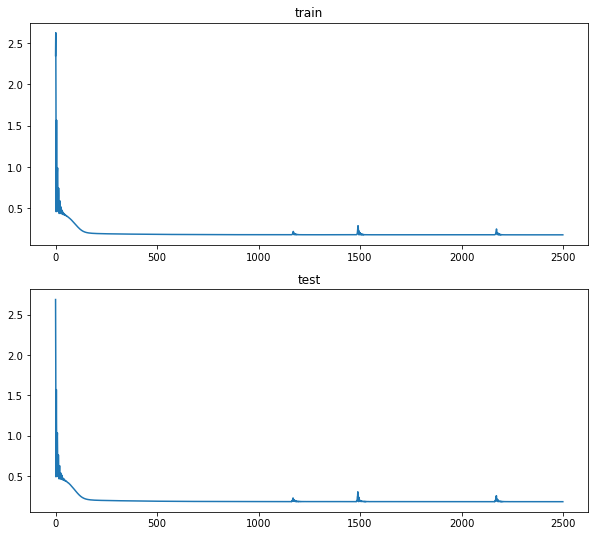

0.1762530505657196


In [61]:
epochs = 2500
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
losses = []
val_losses = []
model.train()
for i in range(epochs):
    #train
    epoch_loss = []
    val_epoch_loss = []
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(X.to('cuda'))

    single_loss = nn.MSELoss()(y_pred, Y.to('cuda')).mean()
    single_loss.backward()
    optimizer.step()
    epoch_loss.append(single_loss.item())
    
    #valid
    model.eval()
    y_pred = model(X_t.to('cuda'))

    single_loss = nn.MSELoss()(y_pred, Y_t.to('cuda')).mean()
    val_epoch_loss.append(single_loss.item())    
    
    clear_output(True)
    losses.append(np.mean(epoch_loss))
    val_losses.append(np.mean(val_epoch_loss))
    
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses)
    ax_2.set_title('test')
    ax_2.plot(val_losses)
    plt.show()
    print(losses[-1])

In [62]:
model.eval()
model.to('cpu')
k = 1
#last_k_step = test[0]
prediction = []
for i in range(k, len(test)):
    pred = test[i-k]
    #if pred > 1:
       # print(pred)
    for j in range(k):
        pred = model(pred).detach()
    prediction.append(pred.item())

In [63]:
(((np.array(prediction) - test[1:].numpy().flatten())**2).mean())**0.5

0.42478119937943404